In [32]:
import mysql.connector

# Connection details
host = 'localhost'
user = 'root'
password = ''
database = 'smartphone_data'
port = 3300

# Establish a connection to the database
connection = mysql.connector.connect(
    host=host,
    user=user,
    password=password,
    database=database,
    port=port
)

print("Koneksi ke database berhasil")


Koneksi ke database berhasil


In [59]:
import pandas as pd
from IPython.display import display

def execute_query_to_dataframe(connection, query):
    try:
        # Create a cursor object
        cursor = connection.cursor(dictionary=True)
        
        # Execute the SQL query
        cursor.execute(query)
        
        # Fetch all the results
        result = cursor.fetchall()
        
        # Convert the results to a Pandas DataFrame
        df = pd.DataFrame(result)
        
        return df
        
    except mysql.connector.Error as err:
        print(f"Error: {err}")
        return None
    finally:
        # Close the cursor but not the connection
        cursor.close()

# Define the SQL query for LEFT JOIN
query = """
SELECT 
    data.No,
    data.Merek,
    data.Tipe,
    data.Bulan,
    data.Jumlah_Stok,
    data.Jumlah_Terjual,
    data.Harga_Satuan_Rp,
    data.Total_Penjualan_Rp,
    data_spesifikasi.Kamera_Utama_MP,
    data_spesifikasi.Kamera_Depan_MP,
    data_spesifikasi.RAM,
    data_spesifikasi.Memori_Internal,
    data_spesifikasi.Baterai_mAh,
    data_spesifikasi.Jenis_Layar
FROM 
    data
LEFT JOIN 
    data_spesifikasi 
ON 
    data.Tipe = data_spesifikasi.Tipe;
"""

# Fetch the data and convert to DataFrame if connection is successful
if connection.is_connected():
    df = execute_query_to_dataframe(connection, query)
    if df is not None and not df.empty:
        display(df)
    else:
        print("No data found or query execution failed.")
else:
    print("No connection to the database.")


,No,Merek,Tipe,Bulan,Jumlah_Stok,Jumlah_Terjual,Harga_Satuan_Rp,Total_Penjualan_Rp,Kamera_Utama_MP,Kamera_Depan_MP,RAM,Memori_Internal,Baterai_mAh,Jenis_Layar
0,1,Samsung,Galaxy S21,Jan,10,8,10000000,80000000,64,10,8GB,128GB,4000,Dynamic AMOLED
1,2,Samsung,Galaxy S21,Feb,9,7,10000000,70000000,64,10,8GB,128GB,4000,Dynamic AMOLED
2,3,Samsung,Galaxy S21,Mar,8,6,10000000,60000000,64,10,8GB,128GB,4000,Dynamic AMOLED
3,4,Samsung,Galaxy S21,Apr,7,5,10000000,50000000,64,10,8GB,128GB,4000,Dynamic AMOLED
4,5,Samsung,Galaxy S21,May,6,4,10000000,40000000,64,10,8GB,128GB,4000,Dynamic AMOLED
5,6,Samsung,Galaxy S21,Jun,5,3,10000000,30000000,64,10,8GB,128GB,4000,Dynamic AMOLED
6,7,Apple,iPhone 13,Jan,15,12,15000000,180000000,12,12,4GB,128GB,3240,Super Retina XDR
7,8,Apple,iPhone 13,Feb,13,10,15000000,150000000,12,12,4GB,128GB,3240,Super Retina XDR
8,9,Apple,iPhone 13,Mar,12,9,15000000,135000000,12,12,4GB,128GB,3240,Super Retina XDR
9,10,Apple,iPhone 13,Apr,11,8,15000000,120000000,12,12,4GB,128GB,3240,Super Retina XDR


In [60]:
# Persiapan data: jumlah terjual per bulan
df_klastering = df[['Bulan', 'Jumlah_Terjual']].copy()

# Pastikan data yang digunakan adalah numerik
df_klastering['Jumlah_Terjual'] = pd.to_numeric(df_klastering['Jumlah_Terjual'], errors='coerce')
df_klastering = df_klastering.dropna()

print("Data untuk klastering:")
display(df_klastering)


Data untuk klastering:


,Bulan,Jumlah_Terjual
0,Jan,8
1,Feb,7
2,Mar,6
3,Apr,5
4,May,4
5,Jun,3
6,Jan,12
7,Feb,10
8,Mar,9
9,Apr,8


In [61]:
from sklearn.cluster import Birch

# Inisialisasi model BIRCH
birch_model = Birch(n_clusters=None, threshold=0.5)

# Fit model BIRCH ke data
birch_model.fit(df_klastering[['Jumlah_Terjual']])

# Prediksi klaster
clusters = birch_model.predict(df_klastering[['Jumlah_Terjual']])

print("Klaster hasil prediksi:")
print(clusters)


Klaster hasil prediksi:
[0 0 1 1 2 2 3 4 4 0 0 1 5 5 3 3 6 4 0 1 1 2 2 7 4 0 0 1 1 2 5 3 3 6 4 4 2
 2 2 2 7 7 1 1 2 2 2 2 0 0]


In [62]:
# Tambahkan hasil klastering ke dataframe asli
df['Cluster'] = clusters

print("DataFrame dengan klaster:")
display(df)


DataFrame dengan klaster:


,No,Merek,Tipe,Bulan,Jumlah_Stok,Jumlah_Terjual,Harga_Satuan_Rp,Total_Penjualan_Rp,Kamera_Utama_MP,Kamera_Depan_MP,RAM,Memori_Internal,Baterai_mAh,Jenis_Layar,Cluster
0,1,Samsung,Galaxy S21,Jan,10,8,10000000,80000000,64,10,8GB,128GB,4000,Dynamic AMOLED,0
1,2,Samsung,Galaxy S21,Feb,9,7,10000000,70000000,64,10,8GB,128GB,4000,Dynamic AMOLED,0
2,3,Samsung,Galaxy S21,Mar,8,6,10000000,60000000,64,10,8GB,128GB,4000,Dynamic AMOLED,1
3,4,Samsung,Galaxy S21,Apr,7,5,10000000,50000000,64,10,8GB,128GB,4000,Dynamic AMOLED,1
4,5,Samsung,Galaxy S21,May,6,4,10000000,40000000,64,10,8GB,128GB,4000,Dynamic AMOLED,2
5,6,Samsung,Galaxy S21,Jun,5,3,10000000,30000000,64,10,8GB,128GB,4000,Dynamic AMOLED,2
6,7,Apple,iPhone 13,Jan,15,12,15000000,180000000,12,12,4GB,128GB,3240,Super Retina XDR,3
7,8,Apple,iPhone 13,Feb,13,10,15000000,150000000,12,12,4GB,128GB,3240,Super Retina XDR,4
8,9,Apple,iPhone 13,Mar,12,9,15000000,135000000,12,12,4GB,128GB,3240,Super Retina XDR,4
9,10,Apple,iPhone 13,Apr,11,8,15000000,120000000,12,12,4GB,128GB,3240,Super Retina XDR,0


In [63]:
def classify_sales(row):
    if row['Jumlah_Terjual'] <= 2:
        return 'Sangat Rendah'
    elif row['Jumlah_Terjual'] <= 5:
        return 'Rendah'
    elif row['Jumlah_Terjual'] <= 10:
        return 'Cukup'
    elif row['Jumlah_Terjual'] <= 20:
        return 'Berpotensi Tinggi'
    elif row['Jumlah_Terjual'] <= 50:
        return 'Tinggi'
    else:
        return 'Sangat Tinggi'

df['Kategori_Penjualan'] = df.apply(classify_sales, axis=1)

print("DataFrame dengan kategori penjualan:")
display(df)


DataFrame dengan kategori penjualan:


,No,Merek,Tipe,Bulan,Jumlah_Stok,Jumlah_Terjual,Harga_Satuan_Rp,Total_Penjualan_Rp,Kamera_Utama_MP,Kamera_Depan_MP,RAM,Memori_Internal,Baterai_mAh,Jenis_Layar,Cluster,Kategori_Penjualan
0,1,Samsung,Galaxy S21,Jan,10,8,10000000,80000000,64,10,8GB,128GB,4000,Dynamic AMOLED,0,Cukup
1,2,Samsung,Galaxy S21,Feb,9,7,10000000,70000000,64,10,8GB,128GB,4000,Dynamic AMOLED,0,Cukup
2,3,Samsung,Galaxy S21,Mar,8,6,10000000,60000000,64,10,8GB,128GB,4000,Dynamic AMOLED,1,Cukup
3,4,Samsung,Galaxy S21,Apr,7,5,10000000,50000000,64,10,8GB,128GB,4000,Dynamic AMOLED,1,Rendah
4,5,Samsung,Galaxy S21,May,6,4,10000000,40000000,64,10,8GB,128GB,4000,Dynamic AMOLED,2,Rendah
5,6,Samsung,Galaxy S21,Jun,5,3,10000000,30000000,64,10,8GB,128GB,4000,Dynamic AMOLED,2,Rendah
6,7,Apple,iPhone 13,Jan,15,12,15000000,180000000,12,12,4GB,128GB,3240,Super Retina XDR,3,Berpotensi Tinggi
7,8,Apple,iPhone 13,Feb,13,10,15000000,150000000,12,12,4GB,128GB,3240,Super Retina XDR,4,Cukup
8,9,Apple,iPhone 13,Mar,12,9,15000000,135000000,12,12,4GB,128GB,3240,Super Retina XDR,4,Cukup
9,10,Apple,iPhone 13,Apr,11,8,15000000,120000000,12,12,4GB,128GB,3240,Super Retina XDR,0,Cukup


In [76]:
# Menghitung jumlah dan persentase distribusi
distribution_counts = df['Kategori_Penjualan'].value_counts()
distribution_percentages = df['Kategori_Penjualan'].value_counts(normalize=True) * 100

# Membuat DataFrame untuk distribusi
distribution_df = pd.DataFrame({
    'Jumlah': distribution_counts,
    'Persentase (%)': distribution_percentages
})

# Menampilkan tabel distribusi
print("Distribusi Jumlah Penjualan Berdasarkan Kategori:")
display(distribution_df)




Distribusi Jumlah Penjualan Berdasarkan Kategori:


,Jumlah,Persentase (%)
Kategori_Penjualan,,
Cukup,19,38.0
Rendah,18,36.0
Berpotensi Tinggi,10,20.0
Sangat Rendah,3,6.0


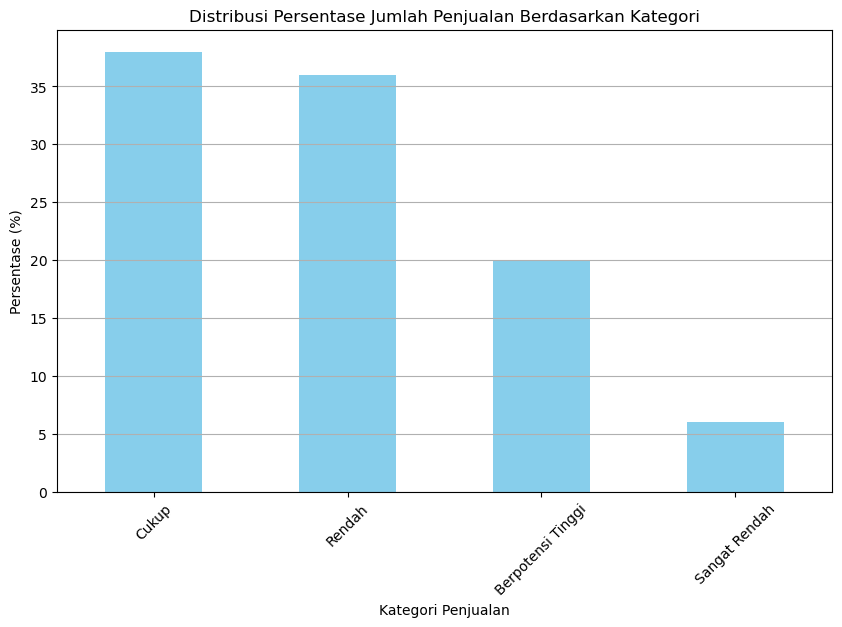

In [77]:
# Menampilkan grafik distribusi
plt.figure(figsize=(10, 6))
distribution_df['Persentase (%)'].plot(kind='bar', color='skyblue')
plt.title('Distribusi Persentase Jumlah Penjualan Berdasarkan Kategori')
plt.xlabel('Kategori Penjualan')
plt.ylabel('Persentase (%)')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

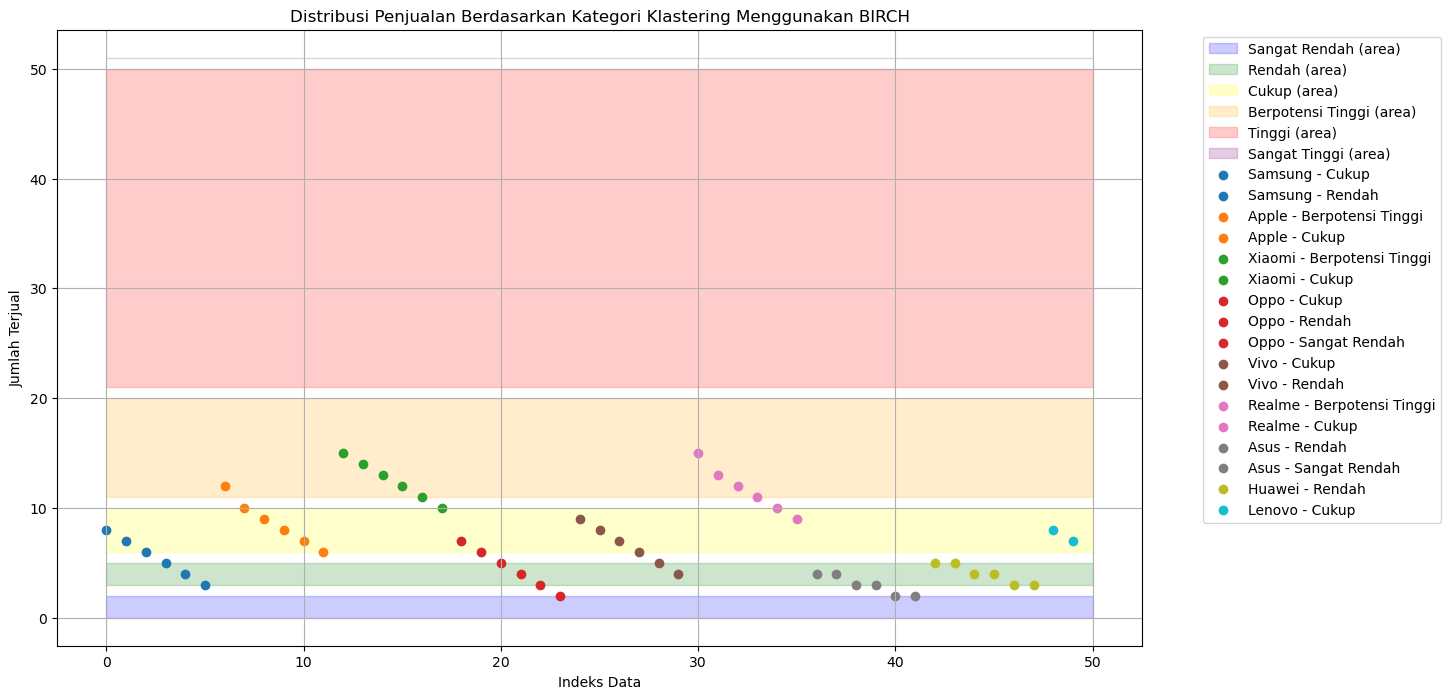

In [92]:
import matplotlib.pyplot as plt
import numpy as np

# Definisikan batasan untuk setiap kelas
class_boundaries = {
    'Sangat Rendah': (0, 2),
    'Rendah': (3, 5),
    'Cukup': (6, 10),
    'Berpotensi Tinggi': (11, 20),
    'Tinggi': (21, 50),
    'Sangat Tinggi': (51, np.inf)
}

# Warna untuk setiap kelas
class_colors = {
    'Sangat Rendah': 'blue',
    'Rendah': 'green',
    'Cukup': 'yellow',
    'Berpotensi Tinggi': 'orange',
    'Tinggi': 'red',
    'Sangat Tinggi': 'purple'
}

# Warna untuk setiap merek
merek_colors = plt.colormaps['tab10'](np.linspace(0, 1, len(df['Merek'].unique())))

# Visualisasi hasil klastering berdasarkan kategori penjualan
plt.figure(figsize=(14, 8))

# Plot area arsiran untuk setiap kelas
for class_name, (lower, upper) in class_boundaries.items():
    plt.fill_betweenx(y=[lower, upper], x1=0, x2=len(df), color=class_colors[class_name], alpha=0.2, label=f'{class_name} (area)')

# Plot data penjualan untuk setiap merek
merek_unique = df['Merek'].unique()
for idx, merek in enumerate(merek_unique):
    subset_merek = df[df['Merek'] == merek]
    for class_name in subset_merek['Kategori_Penjualan'].unique():
        subset_kategori = subset_merek[subset_merek['Kategori_Penjualan'] == class_name]
        plt.scatter(subset_kategori.index, subset_kategori['Jumlah_Terjual'], label=f'{merek} - {class_name}', color=merek_colors[idx])

plt.title('Distribusi Penjualan Berdasarkan Kategori Klastering Menggunakan BIRCH')
plt.xlabel('Indeks Data')
plt.ylabel('Jumlah Terjual')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()




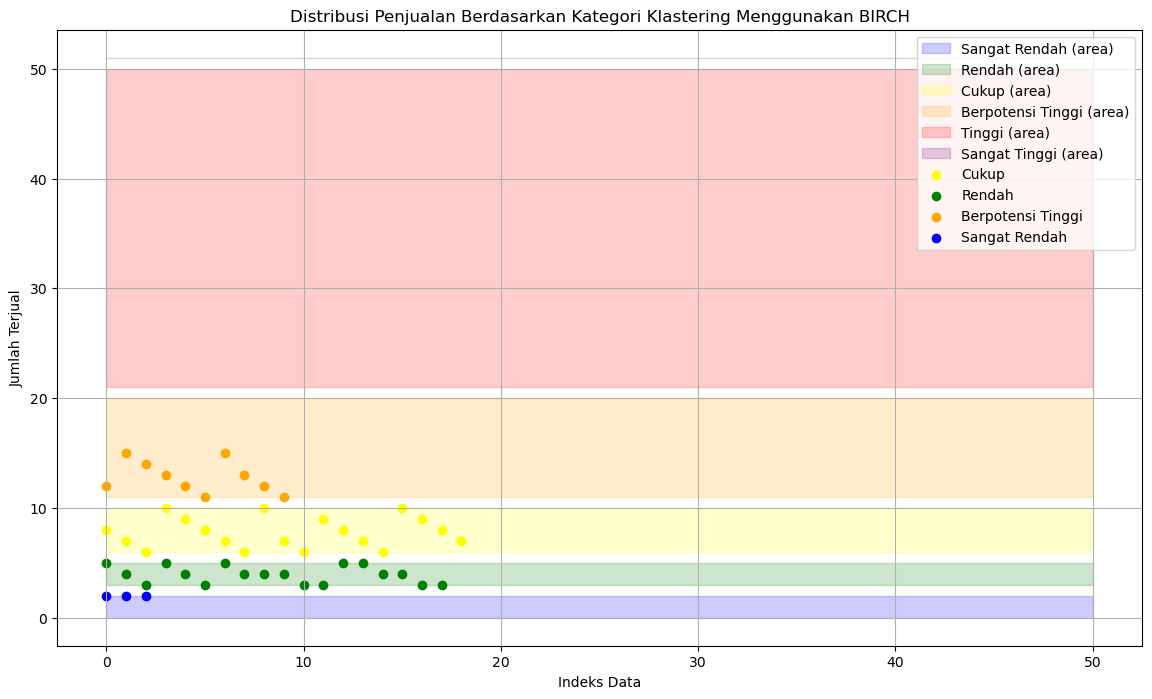

In [93]:
import matplotlib.pyplot as plt
import numpy as np

# Definisikan batasan untuk setiap kelas
class_boundaries = {
    'Sangat Rendah': (0, 2),
    'Rendah': (3, 5),
    'Cukup': (6, 10),
    'Berpotensi Tinggi': (11, 20),
    'Tinggi': (21, 50),
    'Sangat Tinggi': (51, np.inf)
}

# Warna untuk setiap kelas
class_colors = {
    'Sangat Rendah': 'blue',
    'Rendah': 'green',
    'Cukup': 'yellow',
    'Berpotensi Tinggi': 'orange',
    'Tinggi': 'red',
    'Sangat Tinggi': 'purple'
}

# Visualisasi hasil klastering berdasarkan kategori penjualan
plt.figure(figsize=(14, 8))

# Plot area arsiran untuk setiap kelas
for class_name, (lower, upper) in class_boundaries.items():
    plt.fill_betweenx(y=[lower, upper], x1=0, x2=len(df), color=class_colors[class_name], alpha=0.2, label=f'{class_name} (area)')

# Plot data penjualan
for class_name in df['Kategori_Penjualan'].unique():
    subset = df[df['Kategori_Penjualan'] == class_name]
    plt.scatter(range(len(subset)), subset['Jumlah_Terjual'], label=class_name, color=class_colors[class_name])

plt.title('Distribusi Penjualan Berdasarkan Kategori Klastering Menggunakan BIRCH')
plt.xlabel('Indeks Data')
plt.ylabel('Jumlah Terjual')
plt.legend()
plt.grid(True)
plt.show()


In [88]:
# Menghitung jumlah dan persentase distribusi untuk RAM dan ROM
distribution_counts_ram_rom = df['Kategori_RAM_ROM'].value_counts()
distribution_percentages_ram_rom = df['Kategori_RAM_ROM'].value_counts(normalize=True) * 100

# Membuat DataFrame untuk distribusi
distribution_df_ram_rom = pd.DataFrame({
    'Jumlah': distribution_counts_ram_rom,
    'Persentase (%)': distribution_percentages_ram_rom
})

# Menambahkan kolom untuk nilai RAM dan Memori Internal
distribution_df_ram_rom['RAM'] = [', '.join(map(str, df[df['Kategori_RAM_ROM'] == category]['RAM'].unique())) for category in distribution_df_ram_rom.index]
distribution_df_ram_rom['Memori_Internal'] = [', '.join(map(str, df[df['Kategori_RAM_ROM'] == category]['Memori_Internal'].unique())) for category in distribution_df_ram_rom.index]

# Menampilkan tabel distribusi
print("Distribusi Jumlah Penjualan Berdasarkan Kategori RAM dan ROM:")
display(distribution_df_ram_rom)



Distribusi Jumlah Penjualan Berdasarkan Kategori RAM dan ROM:


,Jumlah,Persentase (%),RAM,Memori_Internal
Kategori_RAM_ROM,,,,
Berpotensi Tinggi,30,60.0,8.0,"128.0, 256.0"
Cukup,12,24.0,"4.0, 6.0","128.0, 64.0"
Sangat Tinggi,6,12.0,16.0,256.0
Tinggi,2,4.0,12.0,256.0


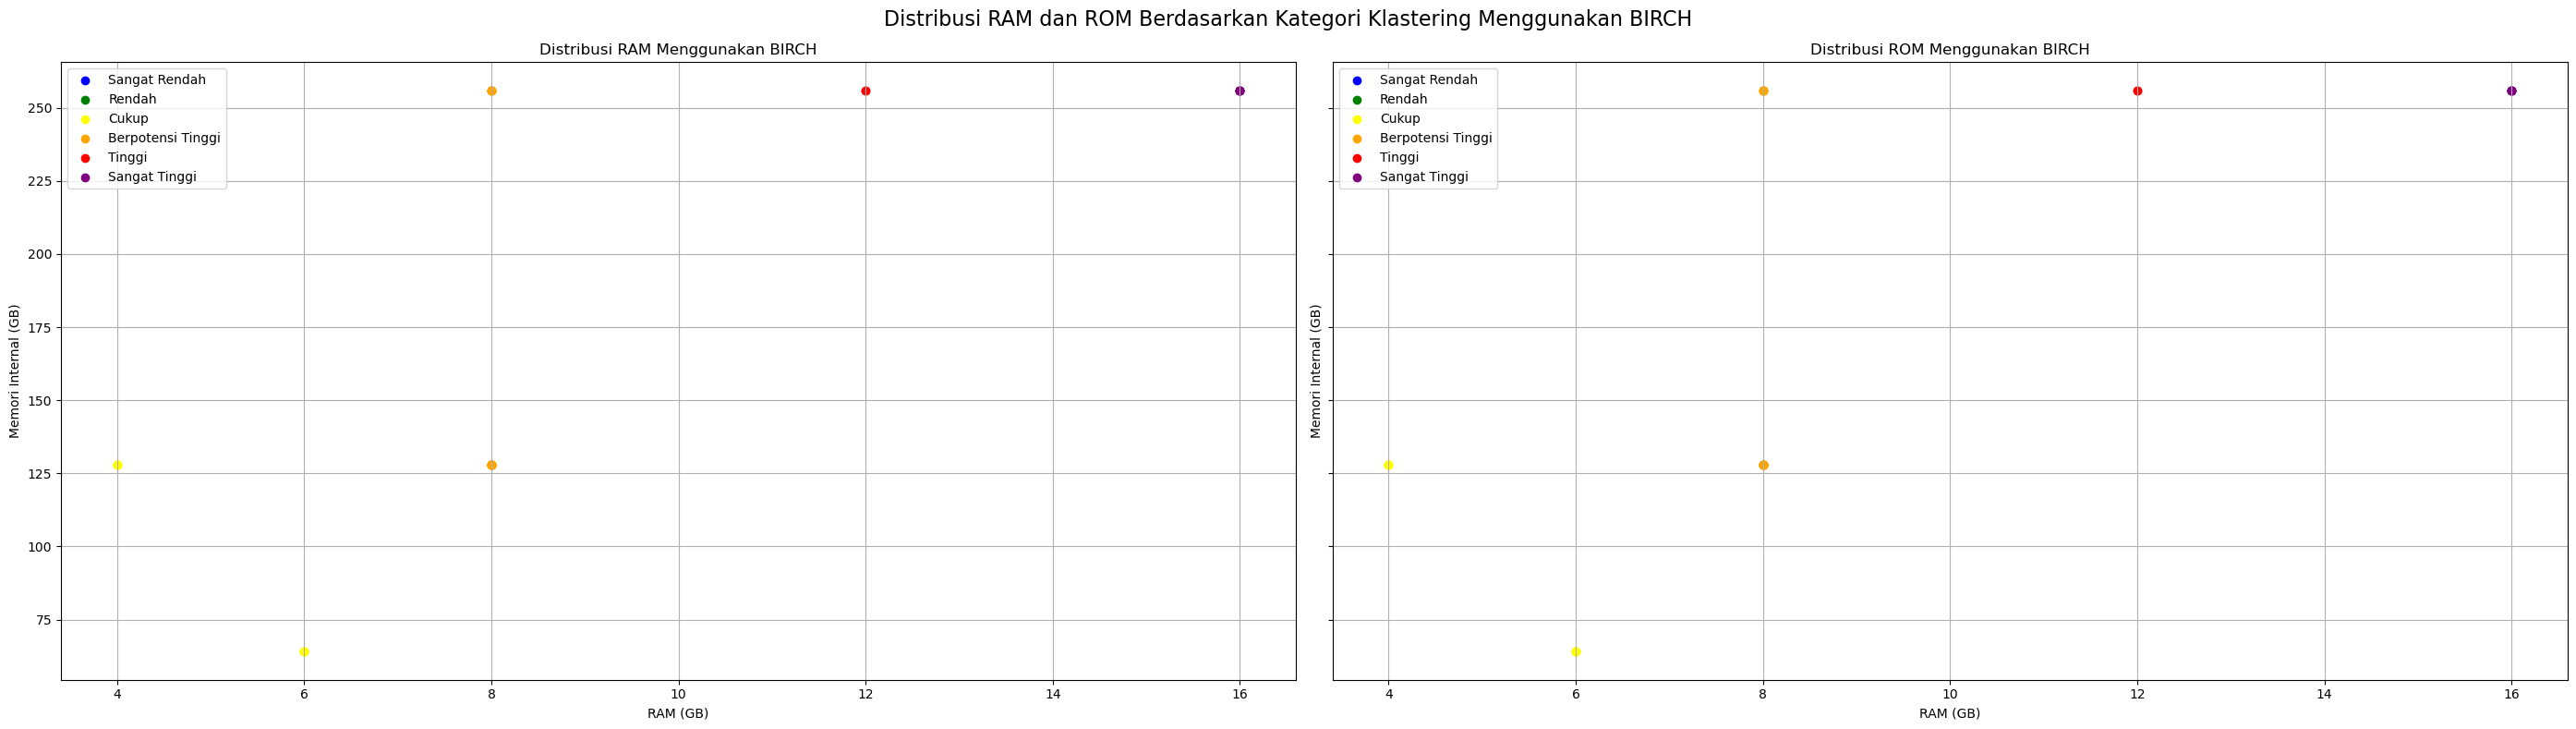

In [94]:
import matplotlib.pyplot as plt

# Menyiapkan data untuk plot
df_ram_rom = df[['RAM', 'Memori_Internal', 'Kategori_RAM_ROM']]

# Warna untuk setiap kelas
class_colors = {
    'Sangat Rendah': 'blue',
    'Rendah': 'green',
    'Cukup': 'yellow',
    'Berpotensi Tinggi': 'orange',
    'Tinggi': 'red',
    'Sangat Tinggi': 'purple'
}

# Plot data RAM dan ROM dengan scatter plot
fig, axes = plt.subplots(1, 2, figsize=(28, 8), sharey=True)

# Plot RAM
for class_name, color in class_colors.items():
    subset = df_ram_rom[df_ram_rom['Kategori_RAM_ROM'] == class_name]
    axes[0].scatter(subset['RAM'], subset['Memori_Internal'], label=f'{class_name}', color=color)

axes[0].set_title('Distribusi RAM Menggunakan BIRCH')
axes[0].set_xlabel('RAM (GB)')
axes[0].set_ylabel('Memori Internal (GB)')
axes[0].legend()
axes[0].grid(True)

# Plot ROM
for class_name, color in class_colors.items():
    subset = df_ram_rom[df_ram_rom['Kategori_RAM_ROM'] == class_name]
    axes[1].scatter(subset['RAM'], subset['Memori_Internal'], label=f'{class_name}', color=color)

axes[1].set_title('Distribusi ROM Menggunakan BIRCH')
axes[1].set_xlabel('RAM (GB)')
axes[1].set_ylabel('Memori Internal (GB)')
axes[1].legend()
axes[1].grid(True)

plt.suptitle('Distribusi RAM dan ROM Berdasarkan Kategori Klastering Menggunakan BIRCH', fontsize=16)
plt.tight_layout()
plt.show()






In [95]:
import pandas as pd

# Asumsi DataFrame `df` sudah ada dari proses sebelumnya

# Menghitung total penjualan per tipe smartphone selama 6 bulan
total_penjualan = df.groupby(['Merek', 'Tipe']).agg({
    'Jumlah_Terjual': 'sum'
}).reset_index()

# Mengurutkan smartphone berdasarkan total penjualan
total_penjualan = total_penjualan.sort_values(by='Jumlah_Terjual', ascending=False)

# Menampilkan tabel hasil
print("Urutan Smartphone Paling Laris Selama 6 Bulan:")
display(total_penjualan)


Urutan Smartphone Paling Laris Selama 6 Bulan:


,Merek,Tipe,Jumlah_Terjual
8,Xiaomi,Redmi Note 10,75
5,Realme,8 Pro,70
0,Apple,iPhone 13,52
7,Vivo,V21,39
6,Samsung,Galaxy S21,33
4,Oppo,Reno 5,27
2,Huawei,P40 Pro,24
1,Asus,ROG Phone 5,18
3,Lenovo,Legion Phone,15


In [97]:
import pandas as pd

# Asumsi DataFrame `df` sudah ada dari proses sebelumnya

# Fungsi untuk mengklasifikasikan jumlah terjual
def classify_sales(jumlah_terjual):
    if jumlah_terjual <= 2:
        return 'Sangat Rendah'
    elif jumlah_terjual <= 5:
        return 'Rendah'
    elif jumlah_terjual <= 10:
        return 'Cukup'
    elif jumlah_terjual <= 20:
        return 'Berpotensi Tinggi'
    elif jumlah_terjual <= 50:
        return 'Tinggi'
    else:
        return 'Sangat Tinggi'

# Membuat pivot table untuk merangkum data penjualan bulanan per tipe dan merek
penjualan_bulanan = df.pivot_table(
    index=['Merek', 'Tipe'],
    columns='Bulan',
    values='Jumlah_Terjual',
    aggfunc='sum'
).reset_index()

# Mengisi nilai NaN dengan 0 (jika ada bulan yang tidak ada penjualan)
penjualan_bulanan = penjualan_bulanan.fillna(0)

# Mengklasifikasikan penjualan untuk setiap bulan
for bulan in ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun']:
    penjualan_bulanan[bulan] = penjualan_bulanan[bulan].apply(classify_sales)

# Menampilkan tabel hasil
print("Status Penjualan Setiap Tipe dan Merek Selama 6 Bulan:")
display(penjualan_bulanan)



Status Penjualan Setiap Tipe dan Merek Selama 6 Bulan:


Bulan,Merek,Tipe,Apr,Feb,Jan,Jun,Mar,May
0,Apple,iPhone 13,Cukup,Cukup,Berpotensi Tinggi,Cukup,Cukup,Cukup
1,Asus,ROG Phone 5,Rendah,Rendah,Rendah,Sangat Rendah,Rendah,Sangat Rendah
2,Huawei,P40 Pro,Rendah,Rendah,Rendah,Rendah,Rendah,Rendah
3,Lenovo,Legion Phone,Sangat Rendah,Cukup,Cukup,Sangat Rendah,Sangat Rendah,Sangat Rendah
4,Oppo,Reno 5,Rendah,Cukup,Cukup,Sangat Rendah,Rendah,Rendah
5,Realme,8 Pro,Berpotensi Tinggi,Berpotensi Tinggi,Berpotensi Tinggi,Cukup,Berpotensi Tinggi,Cukup
6,Samsung,Galaxy S21,Rendah,Cukup,Cukup,Rendah,Cukup,Rendah
7,Vivo,V21,Cukup,Cukup,Cukup,Rendah,Cukup,Rendah
8,Xiaomi,Redmi Note 10,Berpotensi Tinggi,Berpotensi Tinggi,Berpotensi Tinggi,Cukup,Berpotensi Tinggi,Berpotensi Tinggi


In [98]:
import pandas as pd

# Asumsi DataFrame `df` sudah ada dari proses sebelumnya

# Membuat pivot table untuk merangkum data penjualan bulanan per tipe dan merek
penjualan_bulanan = df.pivot_table(
    index=['Merek', 'Tipe'],
    columns='Bulan',
    values='Jumlah_Terjual',
    aggfunc='sum'
).reset_index()

# Mengisi nilai NaN dengan 0 (jika ada bulan yang tidak ada penjualan)
penjualan_bulanan = penjualan_bulanan.fillna(0)

# Menampilkan tabel hasil
print("Penjualan Bulanan Setiap Tipe dan Merek Selama 6 Bulan:")
display(penjualan_bulanan)


Penjualan Bulanan Setiap Tipe dan Merek Selama 6 Bulan:


Bulan,Merek,Tipe,Apr,Feb,Jan,Jun,Mar,May
0,Apple,iPhone 13,8.0,10.0,12.0,6.0,9.0,7.0
1,Asus,ROG Phone 5,3.0,4.0,4.0,2.0,3.0,2.0
2,Huawei,P40 Pro,4.0,5.0,5.0,3.0,4.0,3.0
3,Lenovo,Legion Phone,0.0,7.0,8.0,0.0,0.0,0.0
4,Oppo,Reno 5,4.0,6.0,7.0,2.0,5.0,3.0
5,Realme,8 Pro,11.0,13.0,15.0,9.0,12.0,10.0
6,Samsung,Galaxy S21,5.0,7.0,8.0,3.0,6.0,4.0
7,Vivo,V21,6.0,8.0,9.0,4.0,7.0,5.0
8,Xiaomi,Redmi Note 10,12.0,14.0,15.0,10.0,13.0,11.0


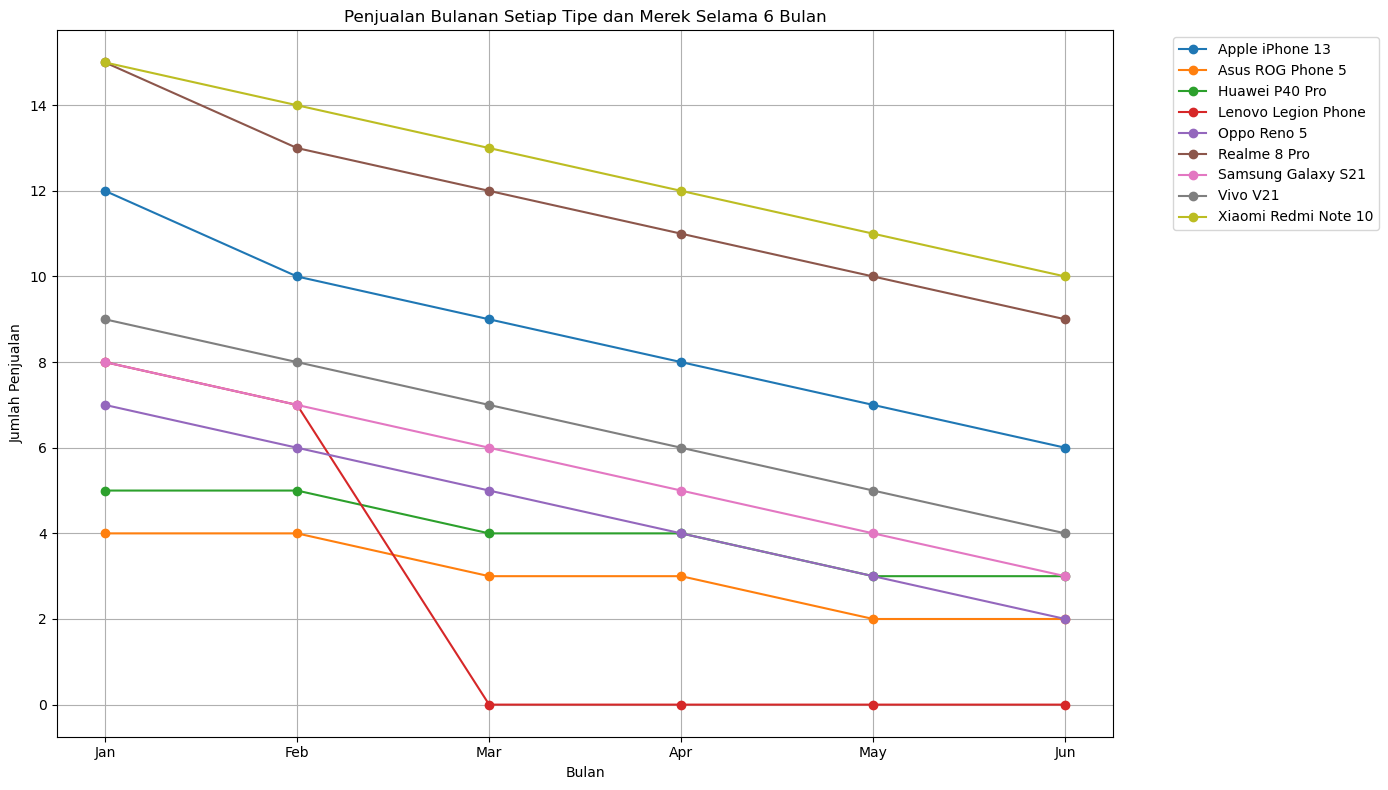

In [99]:
import matplotlib.pyplot as plt

# Mengurutkan bulan
bulan_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun']

# Mengatur ukuran figure
plt.figure(figsize=(14, 8))

# Plot line chart untuk setiap tipe dan merek
for idx, row in penjualan_bulanan.iterrows():
    plt.plot(bulan_order, row[bulan_order], marker='o', label=f"{row['Merek']} {row['Tipe']}")

# Menambahkan judul dan label
plt.title('Penjualan Bulanan Setiap Tipe dan Merek Selama 6 Bulan')
plt.xlabel('Bulan')
plt.ylabel('Jumlah Penjualan')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

# Menampilkan grafik
plt.tight_layout()
plt.show()
